[View in Colaboratory](https://colab.research.google.com/github/J-Fo-S/ml-summer/blob/master/TF_Hub_generative_image_module_mod00.ipynb)

##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# TF-Hub generative image model

<table align="left"><td>
  <a target="_blank"  href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf_hub_generative_image_module.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/tensorflow/hub/blob/master/examples/colab/tf_hub_generative_image_module.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>


This Colab demonstrates use of a TF-Hub module based on a generative adversarial network (GAN). The module maps from N-dimensional vectors, called latent space, to RGB images.

see: https://www.tensorflow.org/hub/modules/google/progan-128/1

https://www.tensorflow.org/hub/

https://www.tensorflow.org/hub/common_signatures/images

https://www.tensorflow.org/api_docs/python/hub/Module

https://damienpontifex.com/2018/04/21/image-classification-using-tensorflow-estimators-and-tensorflow-hub-for-transfer-learning/

https://arxiv.org/abs/1710.10196

try combining with: http://cvl-demos.cs.nott.ac.uk/vrn/

Two examples are provided:
* **Mapping** from latent space to images, and
* Given a target image, **using gradient descent to find** a latent vector that generates an image similar to the target image.

## Optional prerequisites

* Familiarity with [low level Tensorflow concepts](https://www.tensorflow.org/programmers_guide/low_level_intro).
* [Generative Adversarial Network](https://en.wikipedia.org/wiki/Generative_adversarial_network) on Wikipedia.
* Paper on Progressive GANs: [Progressive Growing of GANs for Improved Quality, Stability, and Variation](https://arxiv.org/abs/1710.10196).

In [2]:
# Install the latest Tensorflow version.
!pip -q install --quiet "tensorflow>=1.7"
# Install TF-Hub.
!pip -q install tensorflow-hub
# Install imageio for creating animations.  
!pip -q install imageio
!pip -q install scikit-image

## Latent space interpolation

### Random vectors

Latent space interpolation between two randomly initialized vectors. We will use a TF-Hub module [progan-128](https://tfhub.dev/google/progan-128/1) that contains a pre-trained Progressive GAN.

In [13]:
%tensorflow_version 1.x

#@title Imports and function definitions

import imageio
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import time
from scipy import stats 

try:
    from google.colab import files
except ImportError:
    pass

from IPython import display
from skimage import transform

tf.logging.set_verbosity(tf.logging.ERROR)


# We could retrieve this value from module.get_input_shapes() if we didn't know
# beforehand which module we will be using.
latent_dim = 512

graph = tf.Graph()
config = tf.ConfigProto(device_count = {'GPU': 0})
config.gpu_options.allow_growth = True
tf.logging.set_verbosity(tf.logging.ERROR)

# Simple way to display an image.
def display_image(image):
    plt.figure(figsize=(5,5))
    plt.axis("off")
    plt.imshow(image)
    plt.show()
    
def plot_images(images, ncols=1, nrows=1, size=5, captions=None):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*5, nrows*5))
    for i, _ in enumerate(images):
        axes.ravel()[i].set_axis_off()
        axes.ravel()[i].imshow(images[i])
        if captions is not None:
            axes.ravel()[i].set_title(captions)
    fig.subplots_adjust(wspace=0, hspace=0)
    plt.show()
                                     
# Display multiple images in the same figure.
def display_images(images, captions=None):
    num_horizontally = 5
    f, axes = plt.subplots(
      len(images) // num_horizontally, num_horizontally, figsize=(20, 20))
    for i in range(len(images)):
        axes[i // num_horizontally, i % num_horizontally].axis("off")
        if captions is not None:
            axes[i // num_horizontally, i % num_horizontally].text(0, -3, captions[i])
        axes[i // num_horizontally, i % num_horizontally].imshow(images[i])
    f.tight_layout()
    plt.show()

def get_module_pd_image(pd):
    with graph.as_default():
        module = hub.Module("https://tfhub.dev/google/progan-128/1")
        vector = tf.constant(pd, dtype=tf.float32, shape=[1, latent_dim])
        images = module(vector)

    with tf.Session(graph=graph, config=config) as session:
        session.run(tf.global_variables_initializer())
        #print(vector)
        image_out = session.run(images)[0]
    return image_out

#functions same as module_pd_image on 1x run but can be used for updating multiple iterations
def get_module_input_image(im):
    with graph.as_default():
        module = hub.Module("https://tfhub.dev/google/progan-128/1")
        vector = tf.placeholder(tf.float32, shape=[1, latent_dim])
        images = module(vector)

    with tf.Session(graph=graph, config=config) as session:
        session.run(tf.global_variables_initializer())
        #print(vector)
        image_out = session.run(images, feed_dict={vector:im})[0]
    return image_out

def get_module_seed_image(seed):
    with graph.as_default():
        module = hub.Module("https://tfhub.dev/google/progan-128/1")
        vector = tf.random_normal([1, latent_dim], seed=seed)
        images = module(vector)

    with tf.Session(graph=graph, config=config) as session:
        session.run(tf.global_variables_initializer())
        #print(vector)
        image_out = session.run(images)[0]
    return image_out

# display 20 same visualizations from latent space - just to show feed_dict next run
def get_multi_mod_images(imgs, seed=0):
    images = []
    with graph.as_default():
        module = hub.Module("https://tfhub.dev/google/progan-128/1")

    with tf.Session(graph=graph, config=config) as session:
        vector = tf.random_normal([1, latent_dim], seed=seed)
        session.run(tf.global_variables_initializer())
        for _ in range(imgs):
            image = module(vector)
            im_out = session.run(image)
            images.append(im_out[0])
    return images

# display 20 random visualizations from latent space
# try different mean and dev for random vals
def get_rand_mod_images(imgs):
    images = []
    with graph.as_default():
        module = hub.Module("https://tfhub.dev/google/progan-128/1")

        with tf.Session(graph=graph, config=config) as session:
            vec_holder = tf.placeholder(name='rand', shape=[1, latent_dim], dtype=tf.float32)
            session.run(tf.global_variables_initializer())
        for _ in range(imgs):
            image = module(vec_holder)
            im_out = session.run(image,
            feed_dict={ vec_holder: np.random.normal(loc =0, scale =0.5, size=(1, latent_dim)) })
            images.append(im_out[0])
    return images

def upload_image():
    uploaded = files.upload()
    image = imageio.imread(uploaded[uploaded.keys()[0]])
    return transform.resize(image, [128, 128])

def img_preprocess(img, mode='rgb'):
    if mode is 'rgb':
        img = np.asarray(img).astype(np.float32)/255.0
        img = img[:, :, 0:3]
        img= transform.resize(img, (4096, 4096), preserve_range=True, 
                            order=1, mode='constant')
        #img = img.swapaxes(0,2)
        img = transform.pyramid_reduce(img, downscale=32, sigma=None, order=1, mode='reflect', cval=0)
    return img
    if mode is 'g':  
        img = np.asarray(target_image.convert('LA')).astype(np.float32)/255.0
        img= transform.resize(img, (4096, 4096), preserve_range=True, 
                            order=1, mode='constant')
        #img = img.swapaxes(0,2)
        img = transform.pyramid_reduce(img, downscale=32, sigma=None, order=1, mode='reflect', cval=0)
        return img

#binomial "filter" for 0-1 image      
def img_arr_in(img, i=0, j=1):
    np.random.seed(i)
    img = np.expand_dims(img.ravel(), axis=0)
    dense = np.random.binomial(n=1, p=(j+1)/51.0, size=(img.shape[0], img.shape[1]))
    img = np.multiply(img,dense)
    print(img.shape, dense.shape, i,j)
    img = transform.resize(img, (1,512), preserve_range=True)
    plt.hist(img[0], bins=20)
    return img

# subtracts random vector from 0-1 image
def img_arr_norm_in(img, i, j):
    np.random.seed(i)
    img = np.expand_dims(img.ravel(), axis=0)
    lower = 0
    upper = 1
    mu = 0
    sigma = j*0.2
    N = img.shape[1]
    samples = np.random.normal(mu, sigma, N)
    samples = np.expand_dims(samples, axis=0)
    img = np.subtract(img,samples)
    print(img.shape, samples.shape, i,j)
    img = transform.resize(img, (1,512), preserve_range=True)
    plt.hist(img[0], bins=20)
    return img

# binomial filter for -6 + 6 image (assuming tanh?) - try other ranges/shifts within this range
def img_narr_in(img, i, j):
    np.random.seed(i)
    img = 2*(np.expand_dims(img.ravel(), axis=0))-1
    dense = np.random.binomial(n=1, p=(j+1)/51.0, size=(img.shape[0], img.shape[1]))
    img = np.multiply(img,dense)
    print(img.shape, dense.shape, i,j)
    img = transform.resize(img, (1,512), preserve_range=True)

    img = 6 * (img) 
    plt.hist(img[0], bins=20)
    return img

# subtracts random vector from -1 to 1 image, can expand to -6 to 6 via sigma
def img_narr_norm_in(img, i, j):
    np.random.seed(i)
    img = 2*(np.expand_dims(img.ravel(), axis=0))-1
    mu = 0
    sigma = j*0.5
    N = img.shape[1]
    samples = np.random.normal(mu, sigma, N)
    samples = np.expand_dims(samples, axis=0)
    img = np.add(img,samples)
    print(img.shape, samples.shape, i,j)
    img = transform.resize(img, (1,512), preserve_range=True)
    plt.hist(img[0], bins=20)
    return img

# Given a set of images, show an animation.
def animate(images):
    converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
    imageio.mimsave('./animation.gif', converted_images)
    with open('./animation.gif','rb') as f:
          display.display(display.Image(data=f.read(), height=300))

# Interpolates between two vectors that are non-zero and don't both lie on a
# line going through origin. First normalizes v2 to have the same norm as v1. 
# Then interpolates between the two vectors on the hypersphere.
def interpolate_hypersphere(v1, v2, num_steps):
    v1_norm = tf.norm(v1)
    v2_norm = tf.norm(v2)
    v2_normalized = v2 * (v1_norm / v2_norm)

    vectors = []
    for step in range(num_steps):
        interpolated = v1 + (v2_normalized - v1) * step / (num_steps - 1)
        interpolated_norm = tf.norm(interpolated)
        interpolated_normalized = interpolated * (v1_norm / interpolated_norm)
        vectors.append(interpolated_normalized)
    return tf.stack(vectors)

def find_closest_latent_vector(num_optimization_steps, seed=None):
    images = []
    losses = []
    with graph.as_default():
        module = hub.Module("https://tfhub.dev/google/progan-128/1")
        #set all for reuse regardless of scope name
        with tf.variable_scope('', reuse=tf.AUTO_REUSE):
            initial_vector = tf.random_normal([1, latent_dim], seed=seed)
            vector = tf.get_variable("vec", initializer=initial_vector)
            image = module(vector)
            print(image.shape)
            target_image_difference = tf.reduce_sum(
            tf.losses.absolute_difference(image[0], target_image[:,:,:3]))

            # The latent vectors were sampled from a normal distribution. We can get
            # more realistic images if we regularize the length of the latent vector to 
            # the average length of vector from this distribution.
            regularizer = tf.abs(tf.norm(vector) - np.sqrt(latent_dim))

            loss = target_image_difference + regularizer

            optimizer = tf.train.AdamOptimizer(learning_rate=0.3)
        train = optimizer.minimize(loss)

        with tf.Session(graph=graph, config=config) as session:
            session.run(tf.global_variables_initializer())
            for i in range(num_optimization_steps):
                _, loss_out, im_out = session.run([train, loss, image])
                print(im_out.shape)
                images.append(im_out[0])
                losses.append(loss_out)
                #if i %10==0:
                #    print(loss_out)
        return images, losses

def find_closest_latent_vector2(num_optimization_steps, t_image, seed=None):
    images = []
    losses = []
    with graph.as_default():
        module = hub.Module("https://tfhub.dev/google/progan-128/1")
        t_image = img_preprocess(t_image)
        #set all for reuse regardless of scope name
        with tf.variable_scope('', reuse=tf.AUTO_REUSE):
            initial_vector = tf.random_normal([1, latent_dim], seed=seed)
            vector = tf.get_variable("vec", initializer=initial_vector)
            image = module(vector)
            t_image_difference = tf.reduce_sum(
            tf.losses.absolute_difference(image[0], t_image[:,:,:3]))

            # The latent vectors were sampled from a normal distribution. We can get
            # more realistic images if we regularize the length of the latent vector to 
            # the average length of vector from this distribution.
            regularizer = tf.abs(tf.norm(vector) - np.sqrt(latent_dim))

            loss = t_image_difference + regularizer

            optimizer = tf.train.AdamOptimizer(learning_rate=0.3)
        train = optimizer.minimize(loss)

        with tf.Session(graph=graph, config=config) as session:
            session.run(tf.global_variables_initializer())
            for i in range(num_optimization_steps):
                _, loss_out, im_out = session.run([train, loss, image])
                images.append(im_out[0])
                losses.append(loss_out)
                #if i %10==0:
                #    print(loss_out)
        return images, losses

def interpolate_between_vectors():
    with graph.as_default():
        module = hub.Module("https://tfhub.dev/google/progan-128/1")

        # Change the seed to get different random vectors.
        v1 = tf.random_normal([latent_dim], seed=3)
        v2 = tf.random_normal([latent_dim], seed=1)

        # Creates a tensor with 50 steps of interpolation between v1 and v2.
        vectors = interpolate_hypersphere(v1, v2, 25)

        # Uses module to generate images from the latent space.
        interpolated_images = module(vectors)

    with tf.Session(graph=graph, config=config) as session:
        session.run(tf.global_variables_initializer())
        interpolated_images_out = session.run(interpolated_images)
        animate(interpolated_images_out)
 



-0.9700462462077322 0.9657851883224251


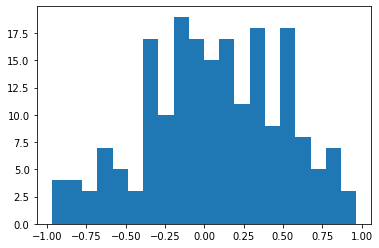

In [6]:
# not currently used but another option for sampling normal distributions within bounds

lower = -1
upper = 1
mu = 0.0
sigma = 0.5
N = 200
samples = stats.truncnorm.rvs(
      (lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=N)
samples = np.expand_dims(samples, axis=0)
print(samples.min(), samples.max())
plt.hist(samples[0], bins=20)
plt.show()

In [7]:
with graph.as_default():
    module = hub.Module("https://tfhub.dev/google/progan-128/1")
    print(module.get_input_info_dict(), module.get_output_info_dict())

{'latent_vector': <hub.ParsedTensorInfo shape=(?, 512) dtype=float32 is_sparse=False>} {'default': <hub.ParsedTensorInfo shape=(?, 128, 128, 3) dtype=float32 is_sparse=False>}


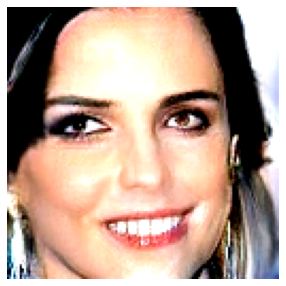

In [8]:
target_image = get_module_seed_image(6000)
display_image(target_image)

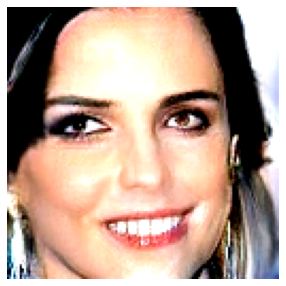

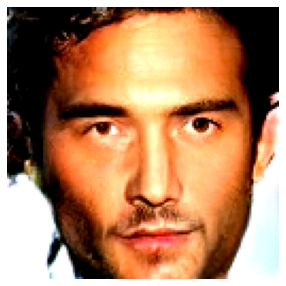

float32 (128, 128, 3) 0.0 [0.3249258  0.3352421  0.35408387]


In [9]:
target_image1 = get_module_seed_image(6000)
display_image(target_image1)
target_image2 = get_module_seed_image(5998)
display_image(target_image2)
print(target_image2.dtype, target_image2.shape, np.min(target_image2), target_image2[1,1,:])

TO-DO: Write function combining a variety of meaningful cross-vector arithmetic (e.g. smile/frown, man/woman, long hair/short hair, etc.)

(1, 49152) (1, 49152) 0 1
(1, 49152) (1, 49152) 0 1


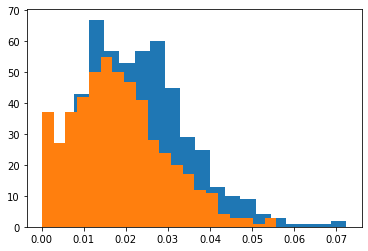

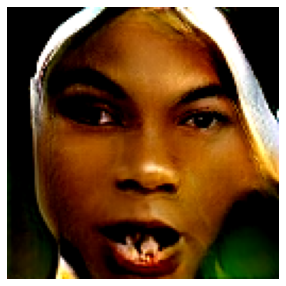

(1, 49152) (1, 49152) 0 1
(1, 49152) (1, 49152) 0 1


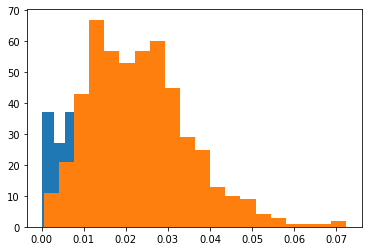

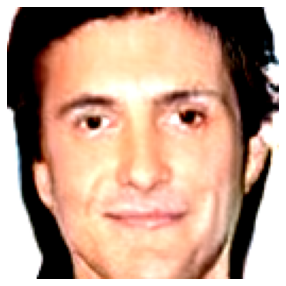

(1, 16384) (1, 16384) 0 1
(1, 49152) (1, 49152) 0 1


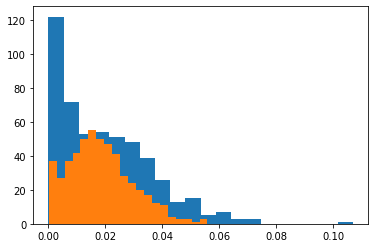

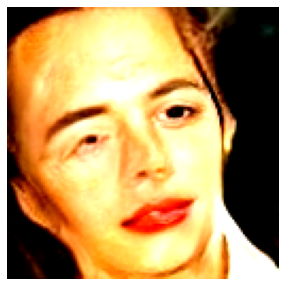

(1, 16384) (1, 16384) 0 1
(1, 49152) (1, 49152) 0 1


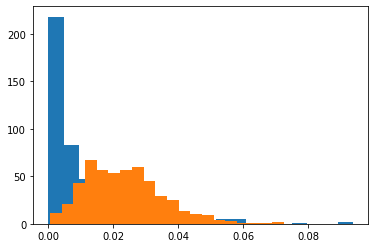

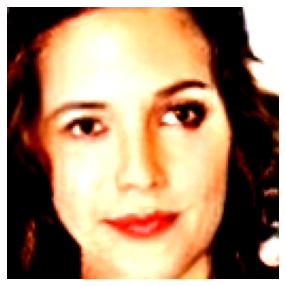

(1, 49152) (1, 49152) 0 1
(1, 16384) (1, 16384) 0 1


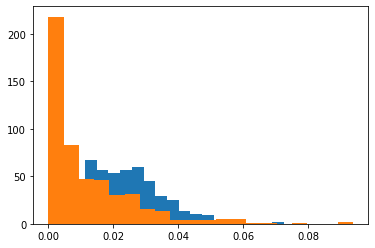

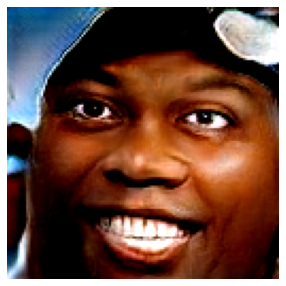

(1, 49152) (1, 49152) 0 1
(1, 16384) (1, 16384) 0 1


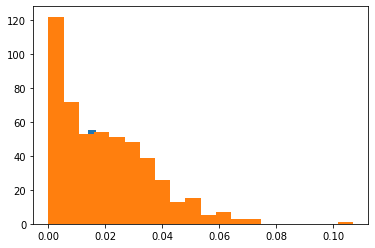

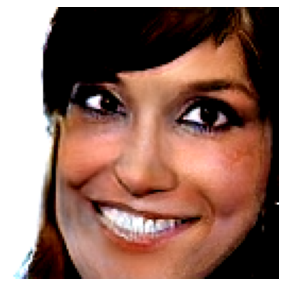

(1, 16384) (1, 16384) 0 1
(1, 16384) (1, 16384) 0 1


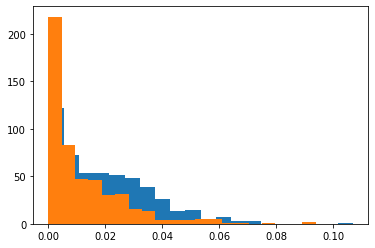

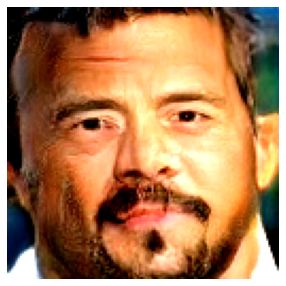

(1, 16384) (1, 16384) 0 1
(1, 16384) (1, 16384) 0 1


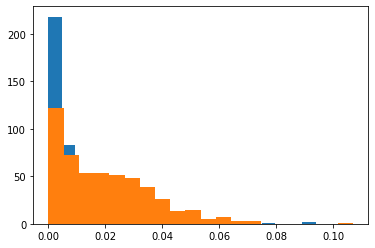

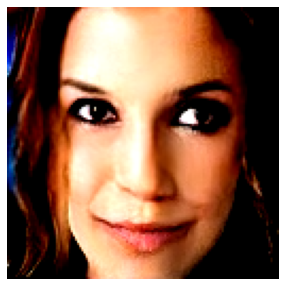

(1, 16384) (1, 16384) 0 1
(1, 16384) (1, 16384) 0 1


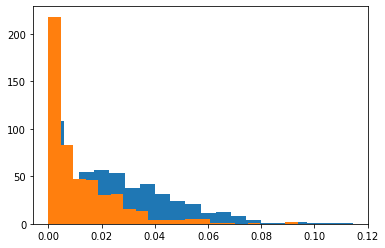

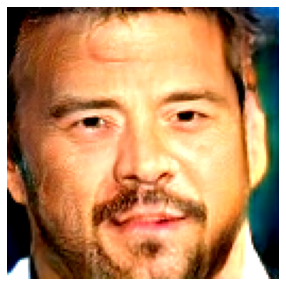

(1, 16384) (1, 16384) 0 1
(1, 16384) (1, 16384) 0 1


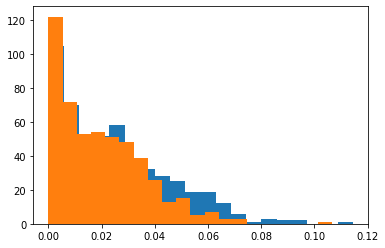

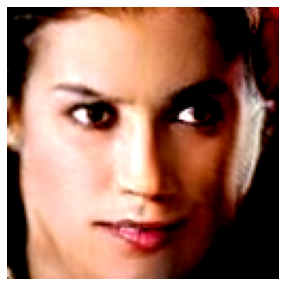

(1, 16384) (1, 16384) 0 1
(1, 16384) (1, 16384) 0 1


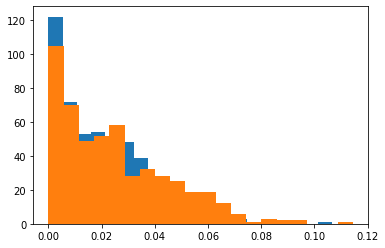

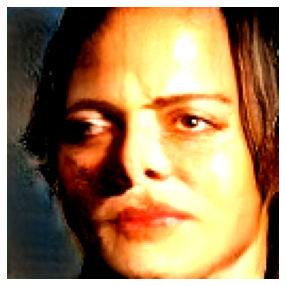

(1, 16384) (1, 16384) 0 1
(1, 16384) (1, 16384) 0 1


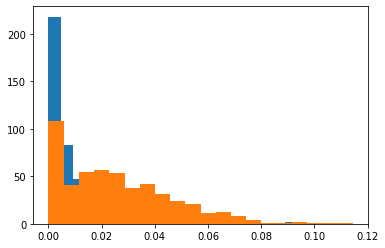

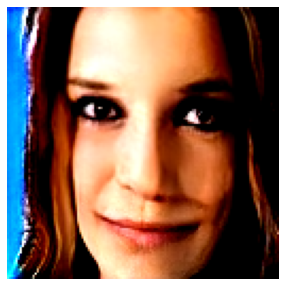

In [14]:
image_return1 = get_module_pd_image(img_arr_in(target_image1) - img_arr_in(target_image2))
display_image(image_return1)
image_return2 = get_module_pd_image(img_arr_in(target_image2) - img_arr_in(target_image1))
display_image(image_return2)
image_return3 = get_module_pd_image(img_arr_in(target_image1[:,:,2]) - img_arr_in(target_image2))
display_image(image_return3)
image_return4 = get_module_pd_image(img_arr_in(target_image2[:,:,2]) - img_arr_in(target_image1))
display_image(image_return4)
image_return5 = get_module_pd_image(img_arr_in(target_image1) - img_arr_in(target_image2[:,:,2]))
display_image(image_return5)
image_return6 = get_module_pd_image(img_arr_in(target_image2) - img_arr_in(target_image1[:,:,2]))
display_image(image_return6)
image_return7 = get_module_pd_image(img_arr_in(target_image1[:,:,2]) - img_arr_in(target_image2[:,:,2]))
display_image(image_return7)
image_return8 = get_module_pd_image(img_arr_in(target_image2[:,:,2]) - img_arr_in(target_image1[:,:,2]))
display_image(image_return8)
image_return9 = get_module_pd_image(img_arr_in(target_image1[:,:,0]) - img_arr_in(target_image2[:,:,2]))
display_image(image_return9)
image_return10 = get_module_pd_image(img_arr_in(target_image2[:,:,0]) - img_arr_in(target_image1[:,:,2]))
display_image(image_return10)
image_return11 = get_module_pd_image(img_arr_in(target_image1[:,:,2]) - img_arr_in(target_image2[:,:,0]))
display_image(image_return11)
image_return12 = get_module_pd_image(img_arr_in(target_image2[:,:,2]) - img_arr_in(target_image1[:,:,0]))
display_image(image_return12)

In [15]:
from io import BytesIO
from PIL import Image
#for local runtime
#import pathlib

#for colab
uploaded = files.upload()

Saving IMG_2525.jpg to IMG_2525.jpg


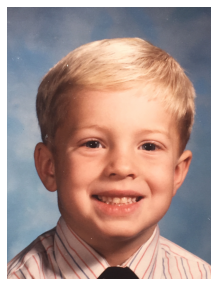

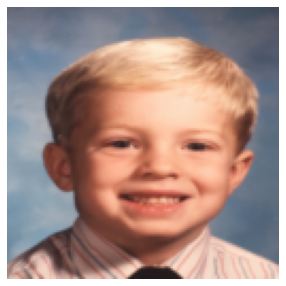

In [16]:
#for colab
target_image = Image.open(BytesIO(uploaded['IMG_2525.jpg']))
#for local runtime
#target_image = Image.open(pathlib.Path('woman.png'))

display_image(target_image)
# Note, this is done in the im_arr_in function automatically
display_image(transform.resize(np.asarray(target_image), (128,128)))

target_image1 = img_preprocess(target_image, mode='rgb')

In [17]:
# Interesting example goes from indistinguished space to distinguished space
for i in range(100):
    for j in range(10):
    #display_image(img_arr_in(target_image1,i))
        display_image(get_module_pd_image(img_arr_norm_in(target_image1,i,j)))

Output hidden; open in https://colab.research.google.com to view.

In [18]:
for i in range(100):
    for j in range(10):
    #display_image(img_arr_in(target_image1,i))
        display_image(get_module_pd_image(img_arr_in(target_image1,i,j)))


Output hidden; open in https://colab.research.google.com to view.

(1, 16384) (1, 16384) 0 0


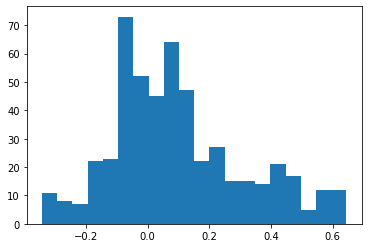

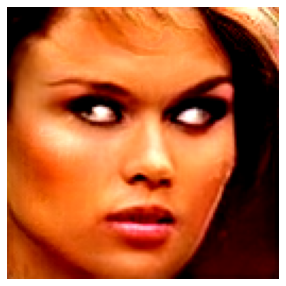

(1, 16384) (1, 16384) 0 1


KeyboardInterrupt: ignored

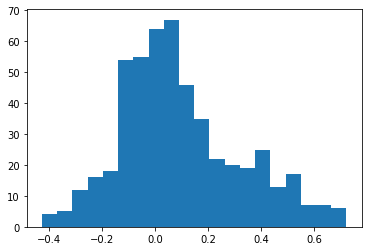

In [19]:
for i in range(100):
    for j in range(10):
    #display_image(img_arr_in(target_image1,i))
        display_image(get_module_input_image(img_narr_norm_in(target_image1,i,j)))

(1, 16384) (1, 16384) 0 0


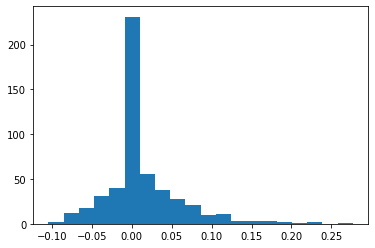

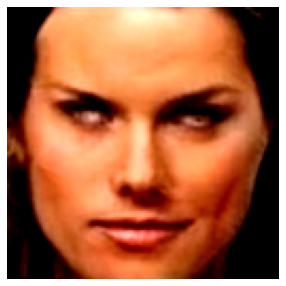

(1, 16384) (1, 16384) 0 1


KeyboardInterrupt: ignored

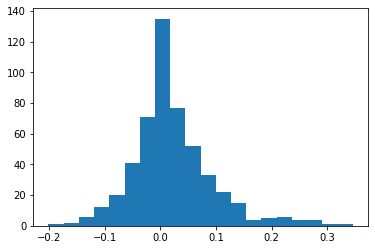

In [20]:
for i in range(100):
    for j in range(5):
        display_image(get_module_pd_image(img_narr_in(target_image1,i,j)))

(1, 16384) (1, 16384) 0 1
(1, 49152) (1, 49152) 0 1


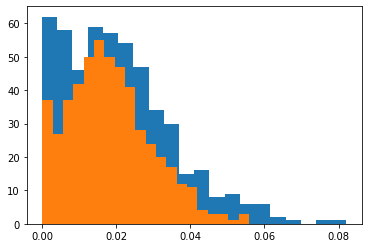

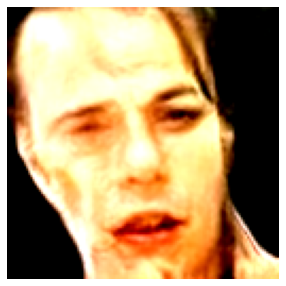

(1, 49152) (1, 49152) 0 1
(1, 16384) (1, 16384) 0 1


KeyboardInterrupt: ignored

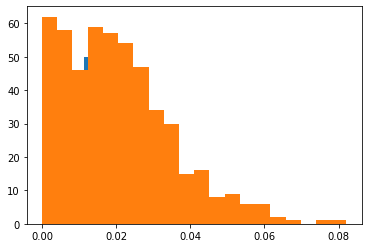

In [21]:
image_return1 = get_module_pd_image(img_arr_in(target_image1) - img_arr_in(target_image2))
display_image(image_return1)
image_return2 = get_module_pd_image(img_arr_in(target_image2) - img_arr_in(target_image1))
display_image(image_return2)
image_return3 = get_module_pd_image(img_arr_in(target_image1[:,:,1]) - img_arr_in(target_image2))
display_image(image_return3)
image_return4 = get_module_pd_image(img_arr_in(target_image2[:,:,1]) - img_arr_in(target_image1))
display_image(image_return4)
image_return5 = get_module_pd_image(img_arr_in(target_image1) - img_arr_in(target_image2[:,:,2]))
display_image(image_return5)
image_return6 = get_module_pd_image(img_arr_in(target_image2) - img_arr_in(target_image1[:,:,2]))
display_image(image_return6)
image_return7 = get_module_pd_image(img_arr_in(target_image1[:,:,2]) - img_arr_in(target_image2[:,:,2]))
display_image(image_return7)
image_return8 = get_module_pd_image(img_arr_in(target_image2[:,:,2]) - img_arr_in(target_image1[:,:,2]))
display_image(image_return8)
image_return9 = get_module_pd_image(img_arr_in(target_image1[:,:,0]) - img_arr_in(target_image2[:,:,2]))
display_image(image_return9)
image_return10 = get_module_pd_image(img_arr_in(target_image2[:,:,0]) - img_arr_in(target_image1[:,:,2]))
display_image(image_return10)
image_return11 = get_module_pd_image(img_arr_in(target_image1[:,:,2]) - img_arr_in(target_image2[:,:,0]))
display_image(image_return11)
image_return12 = get_module_pd_image(img_arr_in(target_image2[:,:,2]) - img_arr_in(target_image1[:,:,0]))
display_image(image_return12)

In [22]:
multi_images = get_multi_mod_images(20)
plot_images(multi_images, 5, 4)

KeyboardInterrupt: ignored

In [ ]:
multi_images = get_rand_mod_images(9)
plot_images(multi_images, 3, 3)

## Finding closest vector in latent space
Fix a target image. As an example use an image generated from the module or upload your own.

After defining a loss function between the target image and the image generated by a latent space variable, we can use gradient descent to find variable values that minimize the loss.

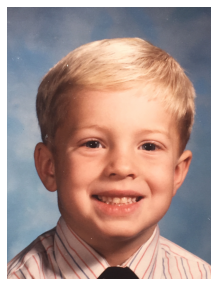

TypeError: ignored

In [30]:
display_image(target_image)
results = find_closest_latent_vector2(100, target_image)
#display_images(results[0], [("Loss: %.2f Iter: %d" % (loss, i)) for i,loss in enumerate(results[1])])
plot_images(results[0], 10, 10, 1, [("Loss: %.2f Iter: %d" % (loss, i)) for i,loss in enumerate(results[1])])

display_image(results[0][-1])

### Playing with the above example
If image is from the module space, the descent is quick and converges to a reasonable sample. Try out descending to an image that is **not from the module space**. The descent will only converge if the image is reasonably close to the space of training images.

How to make it descend faster and to a more realistic image? One can try:
* using different loss on the image difference, e.g. quadratic,
* using different regularizer on the latent vector,
* initializing from a random vector in multiple runs,
* etc.


In [24]:
module_spec = hub.load_module_spec("https://tfhub.dev/google/progan-128/1")
help(module_spec)

Help on _ModuleSpec in module tensorflow_hub.native_module object:

class _ModuleSpec(tensorflow_hub.module_spec.ModuleSpec)
 |  ModuleSpec for Hub's native Module format (backed by SavedModel).
 |  
 |  Method resolution order:
 |      _ModuleSpec
 |      tensorflow_hub.module_spec.ModuleSpec
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, saved_model_handler, checkpoint_variables_path, check_collections=True)
 |      Private constructor.
 |      
 |      Args:
 |        saved_model_handler: SavedModelHandler backing up this Module definition.
 |        checkpoint_variables_path: An optional string to the checkpoint where this
 |          Module variables are checkpointed. If given the variables initializers
 |          are overridden to load from it.
 |        check_collections: Whether to check collections are supported.
 |      
 |      Raises:
 |        ValueError: if SavedModel contains any unexpected value.
 |  
 |  get_input_info_dict(self, signat

In [25]:
# Helper functions for TF Graph visualization
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = tf.compat.as_bytes("<stripped %d bytes>"%size)
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [26]:
show_graph(graph)

In [ ]:
#graph = graph.as_default()
with graph.as_default():
  layers = [op.values() for op in graph.get_operations() if 'conv' in op.name]
  print((layers))

print('Number of layers', len(layers))

In [ ]:
session.close()